## Assignment

In this assignment, you'll continue working with the house prices data. To complete this assignment, submit a link to a Jupyter notebook containing your solutions to the following tasks:

* Load the **houseprices** data from Thinkful's database.
* Reimplement your model from the previous checkpoint.
* Try OLS, Lasso, Ridge, and ElasticNet regression using the same model specification. This time, you need to do **k-fold cross-validation** to choose the best hyperparameter values for your models. Scikit-learn has RidgeCV, LassoCV, and ElasticNetCV that you can utilize to do this. Which model is the best? Why?

**Load the houseprices data from Thinkful's database.**

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error

from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine

import statsmodels.stats.api as sms
import statsmodels.api as sm

# Display preferences.
%matplotlib inline
pd.options.display.float_format = "{:.3f}".format

import warnings

warnings.filterwarnings(action="ignore")

%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [19]:
postgres_user = "dsbc_student"
postgres_pw = "7*.8G9QH21"
postgres_host = "142.93.121.174"
postgres_port = "5432"
postgres_db = "houseprices"

engine = create_engine(
    "postgresql://{}:{}@{}:{}/{}".format(
        postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db
    )
)
houseprices2_df = pd.read_sql_query("select * from houseprices", con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()


houseprices2_df.head(5)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.000,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


<IPython.core.display.Javascript object>

**Reimplement your model from the previous checkpoint.**

In [20]:
houseprices2_df["log_price"] = np.log(houseprices2_df["saleprice"])

houseprices2_df = houseprices2_df[
    [
        "log_price",
        "overallqual",
        "bsmtqual",
        "kitchenqual",
        "grlivarea",
        "garagearea",
        "fullbath",
        "yearbuilt",
        "exterqual",
        "garagefinish",
        "centralair",
    ]
]

hp2_df = houseprices2_df.dropna()

drop_ids = hp2_df.sort_values("grlivarea", ascending=False).iloc[:4].index
print(f"Dropping house ids {list(drop_ids)}")
hp2_df = hp2_df.drop(index=drop_ids)

hp2_df["centralair"] = (hp2_df["centralair"] == "Y").astype(int)

quality_map = {"Fa": 1, "TA": 2, "Gd": 3, "Ex": 4}
hp2_df[["exterqual"]] = hp2_df[["exterqual"]].replace(quality_map)
hp2_df[["kitchenqual"]] = hp2_df[["kitchenqual"]].replace(quality_map)

quality_map2 = {None: 0, "Fa": 1, "TA": 2, "Gd": 3, "Ex": 4}
hp2_df[["bsmtqual"]] = hp2_df[["bsmtqual"]].replace(quality_map2)

garage2_df = pd.get_dummies(hp2_df["garagefinish"], drop_first=True)

hp2_df = pd.concat([hp2_df, garage2_df], axis=1)
hp2_df.drop(columns=["garagefinish"], inplace=True)

Dropping house ids [1298, 523, 1182, 691]


<IPython.core.display.Javascript object>

In [21]:
X = hp2_df.drop(columns=["log_price", "RFn"])
y = hp2_df["log_price"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=32
)

<IPython.core.display.Javascript object>

In [22]:
lrm = LinearRegression()

lrm.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print(
    "R-squared of the model in training set is: {}".format(lrm.score(X_train, y_train))
)
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lrm.score(X_test, y_test)))
print(
    "Mean absolute error of the prediction is: {}".format(
        mean_absolute_error(y_test, y_preds_test)
    )
)
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print(
    "Root mean squared error of the prediction is: {}".format(
        rmse(y_test, y_preds_test)
    )
)
print(
    "Mean absolute percentage error of the prediction is: {}".format(
        np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100
    )
)

R-squared of the model in training set is: 0.8380568201689231
-----Test set statistics-----
R-squared of the model in test set is: 0.835899234076841
Mean absolute error of the prediction is: 0.11747184712690383
Mean squared error of the prediction is: 0.025045671844994687
Root mean squared error of the prediction is: 0.15825824416122747
Mean absolute percentage error of the prediction is: 0.9730359339615233


<IPython.core.display.Javascript object>

**Try OLS, Lasso, Ridge, and ElasticNet regression using the same model specification. This time, you need to do k-fold cross-validation to choose the best hyperparameter values for your models. Scikit-learn has RidgeCV, LassoCV, and ElasticNetCV that you can utilize to do this. Which model is the best? Why?**

In [30]:
alphas = [np.power(10.0, p) for p in np.arange(-40, 40, 1)]

# fit lasso using a grid search for the best alpha
lasso_cv = LassoCV(alphas=alphas, verbose=1, cv=5)
lasso_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)

print("Best alpha value is: {}".format(lasso_cv.alpha_))
print(
    "R-squared of the model in training set is: {}".format(
        lasso_cv.score(X_train, y_train)
    )
)
print("-----Test set statistics-----")
print(
    "R-squared of the model in test set is: {}".format(lasso_cv.score(X_test, y_test))
)
print(
    "Mean absolute error of the prediction is: {}".format(
        mean_absolute_error(y_test, y_preds_test)
    )
)
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print(
    "Root mean squared error of the prediction is: {}".format(
        rmse(y_test, y_preds_test)
    )
)
print(
    "Mean absolute percentage error of the prediction is: {}".format(
        np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100
    )
)

Best alpha value is: 1e-36
R-squared of the model in training set is: 0.8380568201689231
-----Test set statistics-----
R-squared of the model in test set is: 0.8358992340768416
Mean absolute error of the prediction is: 0.11747184712690449
Mean squared error of the prediction is: 0.02504567184499459
Root mean squared error of the prediction is: 0.15825824416122716
Mean absolute percentage error of the prediction is: 0.9730359339615293


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


<IPython.core.display.Javascript object>

Train
---------------------------------
R^2: -98700.97
rmse 194429.66
mae 182362.08
mape 14992.44


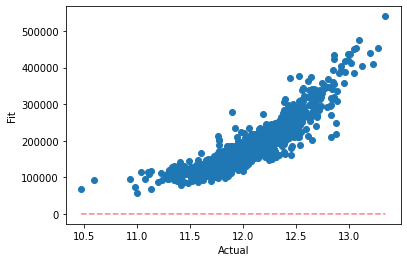

Test
---------------------------------
R^2: -89102.90
rmse 202748.66
mae 190445.23
mape 15591.44


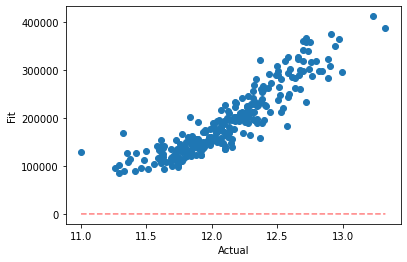

<IPython.core.display.Javascript object>

In [26]:
# now for the test data
y_pred_train = np.exp(lasso_cv.predict(X_train))
y_pred_test = np.exp(lasso_cv.predict(X_test))

print("Train\n---------------------------------")
print(f"R^2: {lasso_cv.score(X_train, np.log(y_train)):.2f}")
eval_preds(y_train, y_pred_train)
print("Test\n---------------------------------")
print(f"R^2: {lasso_cv.score(X_test, np.log(y_test)):.2f}")
eval_preds(y_test, y_pred_test)

In [33]:
alphas = [np.power(10.0, p) for p in np.arange(-40, 40, 1)]

# fit lasso using a grid search for the best alpha
ridge_cv = RidgeCV(alphas=alphas, cv=5)
ridge_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

print("Best alpha value is: {}".format(ridge_cv.alpha_))
print(
    "R-squared of the model in training set is: {}".format(
        ridge_cv.score(X_train, y_train)
    )
)
print("-----Test set statistics-----")
print(
    "R-squared of the model in test set is: {}".format(ridge_cv.score(X_test, y_test))
)
print(
    "Mean absolute error of the prediction is: {}".format(
        mean_absolute_error(y_test, y_preds_test)
    )
)
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print(
    "Root mean squared error of the prediction is: {}".format(
        rmse(y_test, y_preds_test)
    )
)
print(
    "Mean absolute percentage error of the prediction is: {}".format(
        np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100
    )
)

Best alpha value is: 1.0
R-squared of the model in training set is: 0.838051559108952
-----Test set statistics-----
R-squared of the model in test set is: 0.8356737924891101
Mean absolute error of the prediction is: 0.11758309610608941
Mean squared error of the prediction is: 0.025080079582184438
Root mean squared error of the prediction is: 0.15836691441770417
Mean absolute percentage error of the prediction is: 0.973980993704107


<IPython.core.display.Javascript object>

In [34]:
alphas = [np.power(10.0, p) for p in np.arange(-40, 40, 1)]

# fit lasso using a grid search for the best alpha
elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5)
elasticnet_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print(
    "R-squared of the model in training set is: {}".format(
        elasticnet_cv.score(X_train, y_train)
    )
)
print("-----Test set statistics-----")
print(
    "R-squared of the model in test set is: {}".format(
        elasticnet_cv.score(X_test, y_test)
    )
)
print(
    "Mean absolute error of the prediction is: {}".format(
        mean_absolute_error(y_test, y_preds_test)
    )
)
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print(
    "Root mean squared error of the prediction is: {}".format(
        rmse(y_test, y_preds_test)
    )
)
print(
    "Mean absolute percentage error of the prediction is: {}".format(
        np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100
    )
)

Best alpha value is: 1e-16
R-squared of the model in training set is: 0.8380568201689231
-----Test set statistics-----
R-squared of the model in test set is: 0.8358992340768413
Mean absolute error of the prediction is: 0.11747184712690452
Mean squared error of the prediction is: 0.025045671844994632
Root mean squared error of the prediction is: 0.1582582441612273
Mean absolute percentage error of the prediction is: 0.9730359339615304


<IPython.core.display.Javascript object>

The ols regression did just as well as the lasso, ridge, and elasticnet, but with much lower computation cost.